# Plot the streamlines for LLC4320 surface flow

We will be using just one level (the surface) of a single snapshot in time to make it faster.
This will create a particle moving in 2D at the surface.
The trajectories are pre-computed by `compute_LLC4320_particle_trajectories.ipynb` then plotted in this notebook.

Setup and import packages 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

## Load Data
If the particle trajectory location and speed data is already pre-computed, then just load it (otherwise, run `compute_LLC4320_particle_trajectories.ipynb`). 
Also, check for the topography data and download if necessary.

In [2]:
path_to_file_lats = 'LLC4320lats.npy'
path_lats = Path(path_to_file_lats)
path_to_file_lons = 'LLC4320lons.npy'
path_lons = Path(path_to_file_lons)
path_to_file_spds = 'LLC4320spds.npy'
path_spds = Path(path_to_file_spds)

if path_lats.is_file() & path_lons.is_file() & path_spds.is_file():
    print(f'The files {path_to_file_lats} and {path_to_file_lons} and {path_to_file_spds} exist...reading...')
    lons = np.load('LLC4320lons.npy')
    lats = np.load('LLC4320lats.npy')
    spds = np.load('LLC4320spds.npy')
else:
    print(f'The file {path_to_file_lats} or {path_to_file_lons} or {path_to_file_spds} does not exist.\n Run `compute_LLC4320_particle_trajectories.ipynb` to create them.\n\n')
    exit()

# Download the topography data if you don't already have it.
path_to_file_topo = 'ETOPO1_Ice_g_gmt4.grd'
path_topo = Path(path_to_file_topo)
if not(path_topo.is_file()):
    print(f'The file {path_to_file_topo} does not exist...downloading...')
    !wget https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd.gz 
    !gunzip ETOPO1_Ice_g_gmt4.grd.gz
else:
    print(f'The file {path_to_file_topo} exists...reading...')
    
grid = xr.open_dataset('ETOPO1_Ice_g_gmt4.grd', decode_cf=True, engine='netcdf4')
grid=grid.where(grid.z>0)      # We throw away the underwater part of the topography. 

The files LLC4320lats.npy and LLC4320lons.npy and LLC4320spds.npy exist...reading...
The file ETOPO1_Ice_g_gmt4.grd exists...reading...


To speed up the computation, we transform the lat lon outside the plotting for-loop. 

### Define plotting function

In [3]:
def plot_hemisphere(traj_data,spds,grid,ymins):
    
    xx = traj_data[:,:,0]
    yy = traj_data[:,:,1]
    # bins = 4      # Production plot
    bins = 64     # Quick plot for testing

    for i in range(0,lons.shape[1],bins):
        if i%512==0:
            print(i,end = ' ')
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x)-np.min(x)>300:
            x[x<0]+=360
        dydx = (0.5 * (spds.T[i][:-1] + spds.T[i][1:]))[1:]  # first derivative

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1.)
        lc = LineCollection(segments, cmap='GnBu_r', norm=norm)
    
    # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        line = axs.add_collection(lc)
    print('finished plotting lines (lazily)')
    axs.pcolormesh(grid.x[::bins], 
                   grid.y[::bins], 
                   grid.z[::bins,::bins], 
                   transform=ccrs.PlateCarree(), 
                   cmap='bone',vmin= -3000,vmax = 4500,
                   zorder = 20
               )
    print('finished making the map')

# Tidy up
    axs.set_facecolor('lightsteelblue')
    axs.set_extent([-1e4, 1e4, ymins[0], ymins[1]], crs=ccrs.PlateCarree())
    plt.tight_layout()

### Northern hemisphere

0 512 1024 1536 2048 2560 3072 3584 4096 4608 5120 5632 6144 6656 7168 7680 8192 8704 9216 9728 10240 10752 11264 11776 12288 12800 13312 13824 14336 14848 15360 15872 16384 16896 17408 17920 18432 18944 19456 19968 20480 20992 21504 22016 22528 23040 23552 24064 24576 25088 25600 26112 26624 27136 27648 28160 28672 29184 29696 30208 30720 31232 31744 32256 32768 33280 33792 34304 34816 35328 35840 36352 36864 37376 37888 38400 38912 39424 39936 40448 40960 41472 41984 42496 43008 43520 44032 44544 45056 45568 46080 46592 47104 47616 48128 48640 49152 49664 50176 50688 51200 51712 52224 52736 53248 53760 54272 54784 55296 55808 56320 56832 57344 57856 58368 58880 59392 59904 60416 60928 61440 61952 62464 62976 63488 64000 64512 65024 65536 66048 66560 67072 67584 68096 68608 69120 69632 70144 70656 71168 71680 72192 72704 73216 73728 74240 74752 75264 75776 76288 76800 77312 77824 78336 78848 79360 79872 80384 80896 81408 81920 82432 82944 83456 83968 84480 84992 85504 86016 86528 8704

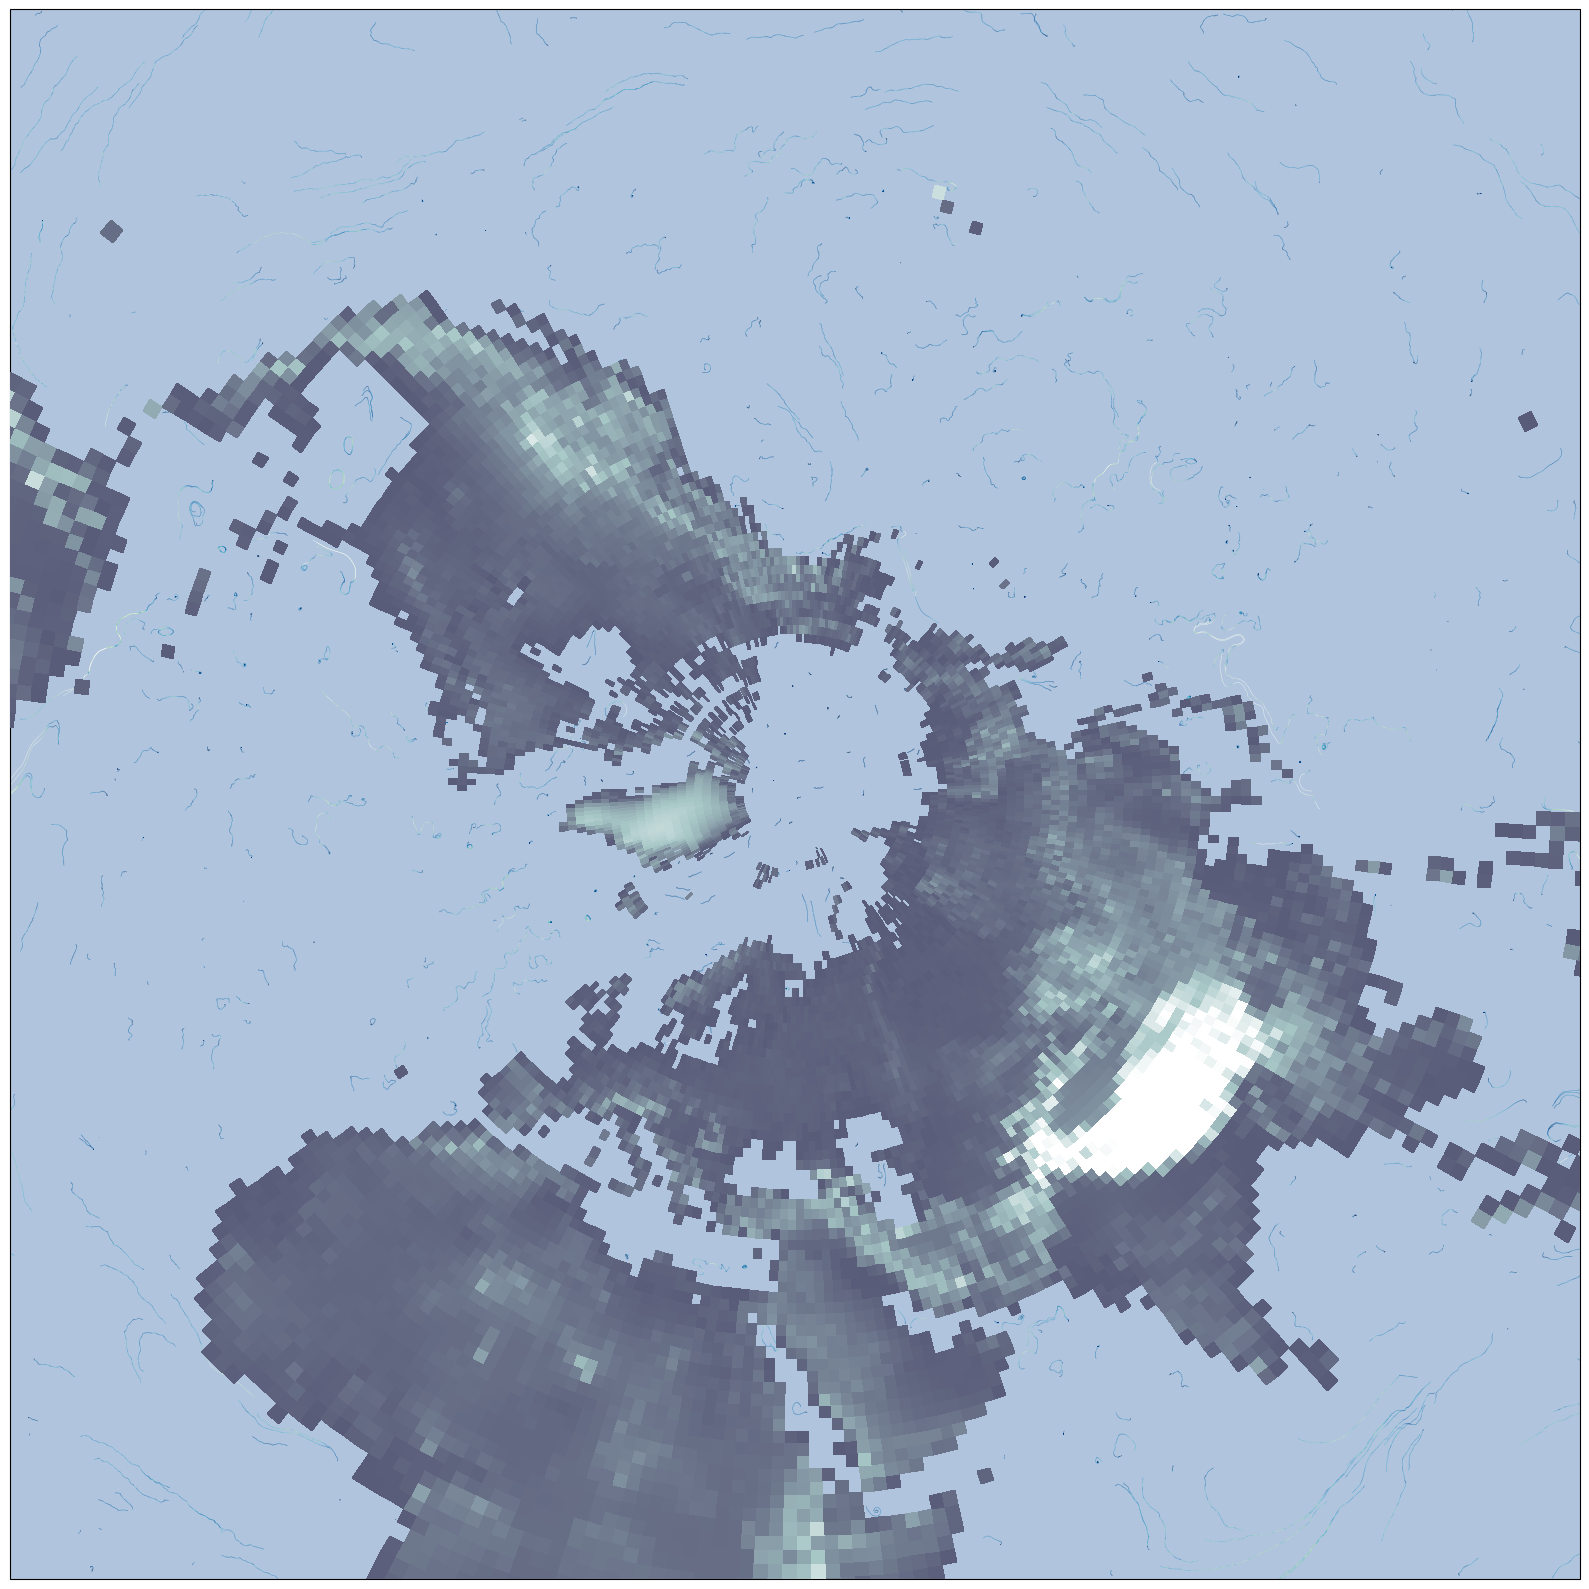

In [4]:
%%time
proj = ccrs.NorthPolarStereo(central_longitude=38.0)
traj_data = proj.transform_points(ccrs.PlateCarree(),lons,lats)
fig = plt.figure(figsize=(16, 16))
axs = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=38.0))    
ymins = np.array([6.5, 1000])
plot_hemisphere(traj_data,spds,grid,ymins)
plt.savefig('NorthernHemisphere.pdf')

### Southern hemisphere

0 512 1024 1536 2048 2560 3072 3584 4096 4608 5120 5632 6144 6656 7168 7680 8192 8704 9216 9728 10240 10752 11264 11776 12288 12800 13312 13824 14336 14848 15360 15872 16384 16896 17408 17920 18432 18944 19456 19968 20480 20992 21504 22016 22528 23040 23552 24064 24576 25088 25600 26112 26624 27136 27648 28160 28672 29184 29696 30208 30720 31232 31744 32256 32768 33280 33792 34304 34816 35328 35840 36352 36864 37376 37888 38400 38912 39424 39936 40448 40960 41472 41984 42496 43008 43520 44032 44544 45056 45568 46080 46592 47104 47616 48128 48640 49152 49664 50176 50688 51200 51712 52224 52736 53248 53760 54272 54784 55296 55808 56320 56832 57344 57856 58368 58880 59392 59904 60416 60928 61440 61952 62464 62976 63488 64000 64512 65024 65536 66048 66560 67072 67584 68096 68608 69120 69632 70144 70656 71168 71680 72192 72704 73216 73728 74240 74752 75264 75776 76288 76800 77312 77824 78336 78848 79360 79872 80384 80896 81408 81920 82432 82944 83456 83968 84480 84992 85504 86016 86528 8704

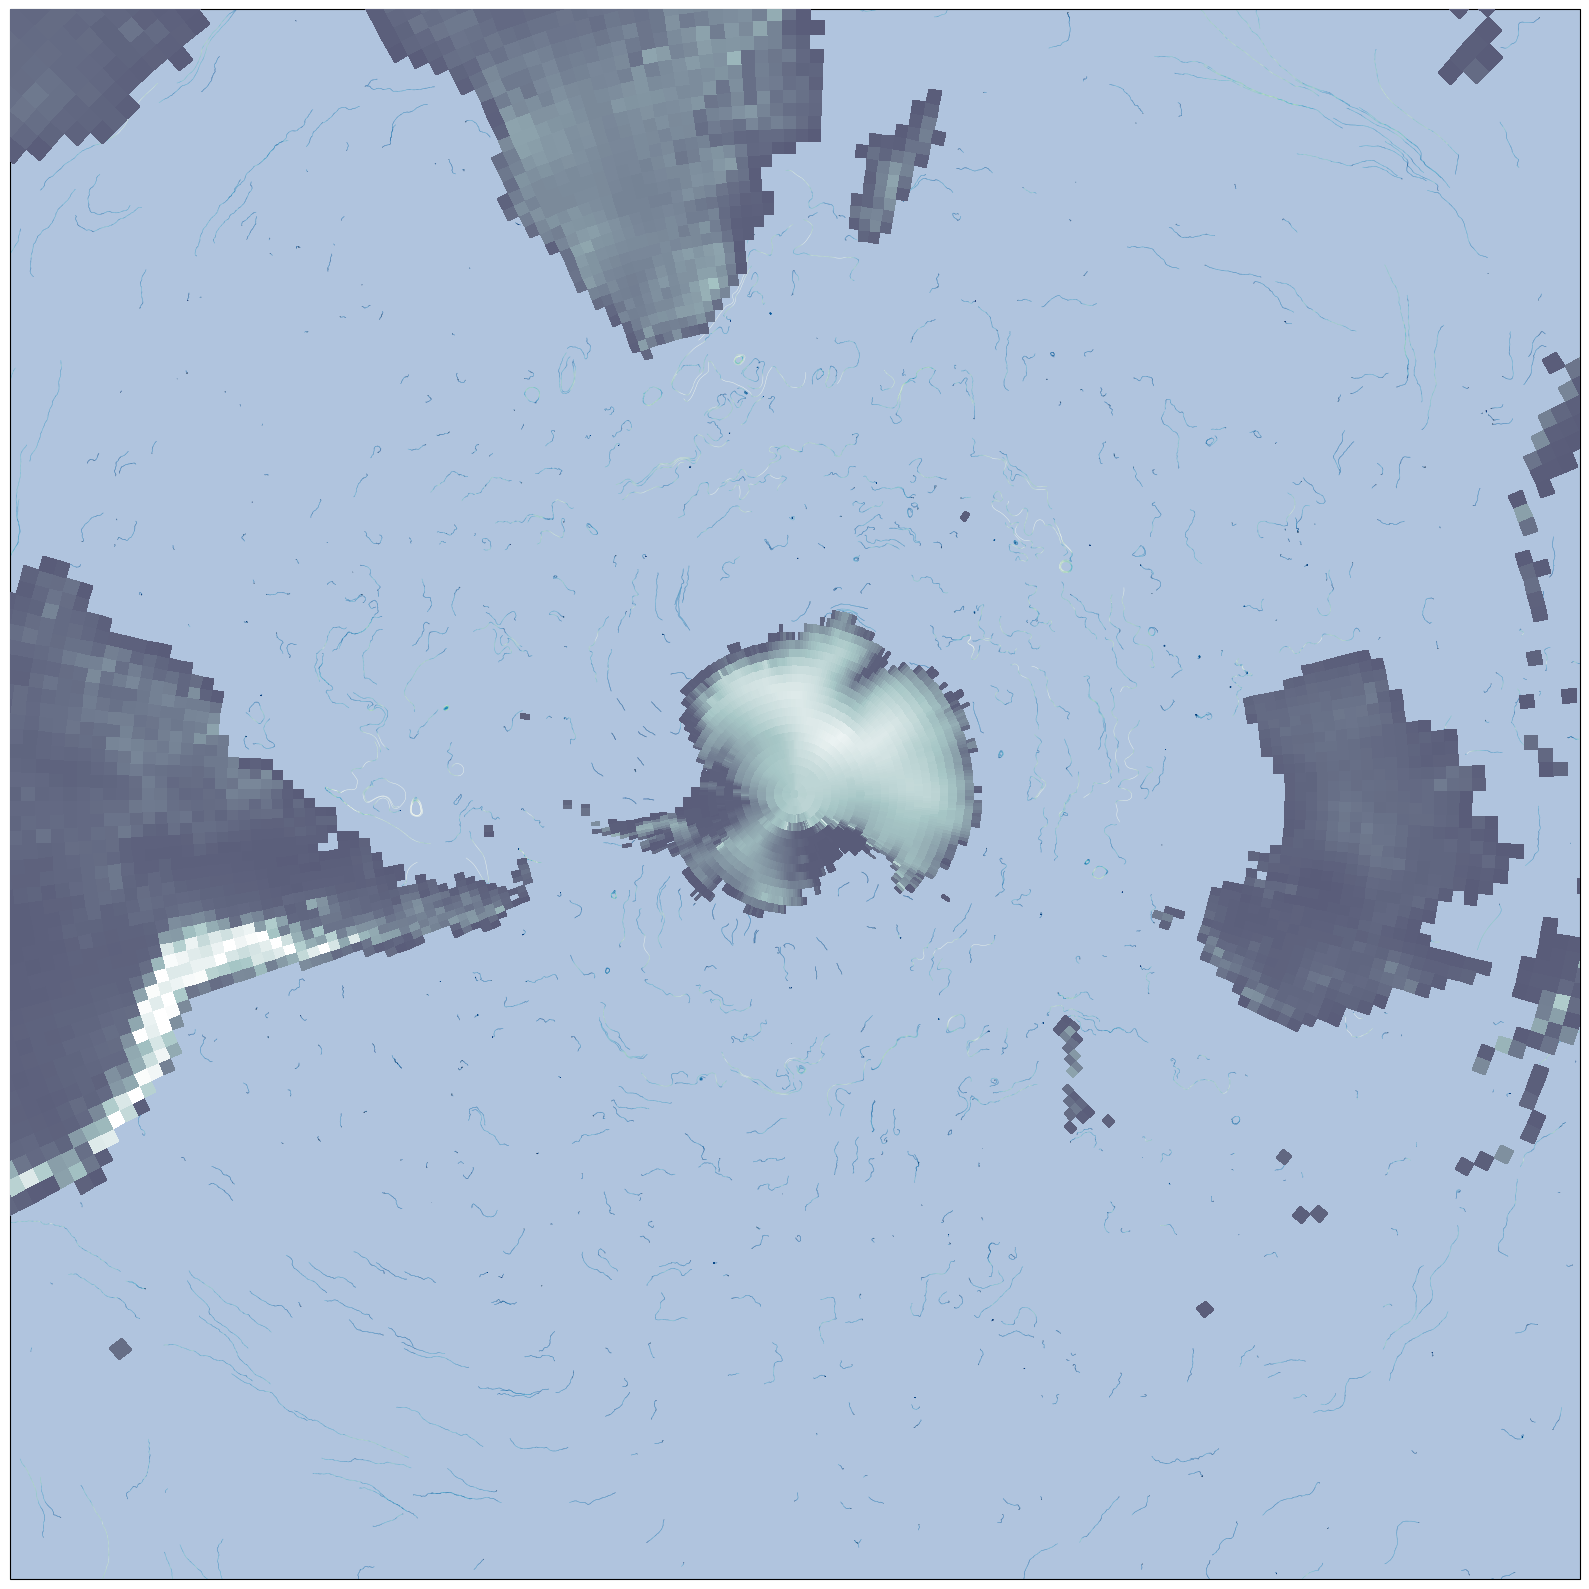

In [5]:
%%time
proj = ccrs.SouthPolarStereo(central_longitude=38.0)
traj_data = proj.transform_points(ccrs.PlateCarree(),lons,lats)
fig = plt.figure(figsize=(16, 16))
axs = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=38.0))
ymins = np.array([-1000, -6.5])
plot_hemisphere(traj_data,spds,grid,ymins)
plt.savefig('SouthernHemisphere.pdf')